<ipython-input-1-f3209942985c>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = th.from_numpy(imageio.imread(f'./{M}.png') / 255.).to(device)


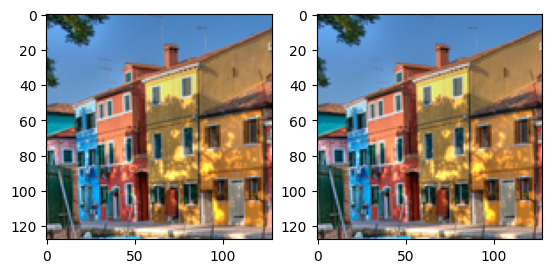

In [1]:
import matplotlib.pyplot as plt
import imageio
import torch as th

# It is highly recommended to set up pytorch to take advantage of CUDA GPUs!
device = th.device('cuda') if th.cuda.is_available() else th.device('cpu')

# Choose the size of the image here. Prototyping is easier with 128.
M = 128
# The reference implementation works in chunks. Set this as high as possible
# while fitting the intermediary calculations in memory.
simul = M ** 2 // 4 #1024

im = th.from_numpy(imageio.imread(f'./{M}.png') / 255.).to(device)

# Visualization
_, ax = plt.subplots(1, 2)
ax[0].imshow(im.cpu().numpy())
artist = ax[1].imshow(im.cpu().numpy())

for zeta in [1,4]:
    y, x = th.meshgrid(
        th.linspace(-zeta, zeta, M, device=device),
        th.linspace(-zeta, zeta, M, device=device),
        indexing='xy'
    )
    features = th.cat((im, y[..., None], x[..., None]), dim=-1).reshape(-1, 5)
    for h in [0.1,0.3]:
        # The `shifted` array contains the iteration variables
        shifted = features.clone()
        # The `to_do` array contains the indices of the pixels for which the
        # stopping criterion is _not_ yet met.
        to_do = th.arange(M ** 2, device=device)

        threshold = 1e-6  # Stopping criterion threshold
        h_squared = h ** 2  # Bandwidth squared for comparison
        while len(to_do):
            # We walk through the points in `shifted` in chunks of `simul`
            # points. Note that for each point, you should compute the distance
            # to _all_ other points, not only the points in the current chunk.
            chunk = shifted[to_do[:simul]].clone()

            # TODO: Mean shift iterations (15), writing back the result into shifted.
            # Compute distances between the current chunk and all points

            diff = chunk[:,None,:] - features[None,:,:]                      # (simul, M**2, 5)
            distances_squared = th.sum(diff ** 2, dim=-1) / h_squared       # (simul, M**2)

            indicator = distances_squared <= 1.0                            # (simul, M**2)
            card = indicator.sum(dim=1)                                     # (simul)
            neighbour_sum = (indicator[..., None] * features).sum(dim=1)     # (simul, 5)
            updated_chunk = neighbour_sum / card[..., None]                 # (simul, 5)

            shifted[to_do[:simul]] = updated_chunk

            # TODO: Termination criterion (17). cond should be True for samples
            # that need updating. Note that chunk contains the 'old' values.
            movement = th.sum((updated_chunk - chunk) ** 2, dim=-1)     # (simul,)
            cond = movement >= threshold                                # (simul,)

            # We only keep the points for which the stopping criterion is not met.
            # `cond` should be a boolean array of length `simul` that indicates
            # which points should be kept.
            to_do = to_do[th.cat((
                cond, cond.new_ones(to_do.shape[0] - cond.shape[0])
            ))]
            artist.set_data(shifted.view(M, M, 5).cpu()[:, :, :3])
            plt.pause(0.01)

        # Reference images were saved using this code.
        imageio.imsave(
            f'./results/{M}/zeta_{zeta:1.1f}_h_{h:.2f}.png',
            (shifted.reshape(M, M, 5)[..., :3].clone().cpu() * 255).type(th.uint8).numpy())
